In [1]:
# coding: UTF-8
%matplotlib notebook
import glob
import os
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class_name_modelnet40 = [
'airplane',
'bookshelf',
'chair',
'desk',
'glass_box',
'laptop',
'person',
'range_hood',
'stool',
'tv_stand',
'bathtub',
'bottle',
'cone',
'door',
'guitar',
'mantel',
'piano',
'sink',
'table',
'vase',
'bed',
'bowl',
'cup',
'dresser',
'keyboard',
'monitor',
'plant',
'sofa',
'tent',
'wardrobe',
'bench',
'car',
'curtain',
'flower_pot',
'lamp',
'night_stand',
'radio',
'stairs',
'toilet',
'xbox',
]

In [3]:
n_points = 4096

In [28]:
train_or_test = ["train","test"]

In [4]:
def load_off(filename):
    # read OFF file
    with open(filename,"r") as handle:
        off = handle.read().rstrip().split("\n")

    #get params and faces
    params = list(map(int, off[1].split(" ")))
    n_vertices = params[0]
    n_faces = params[1]

    # read  Vertex coordinates
    vertices = []
    for n in range(n_vertices):
        coords = list(map(float, off[2+n].split()))
        vertices.append(coords)

    # read information of faces
    faces = []
    for n in range(n_faces):
        connects = list(map(int, off[2 + n_vertices + n].split(" ")))[1:]
        faces.append(connects)

    return vertices, faces


In [5]:
def calc_vector_norm(a):
#     何も分からん
    norm = 0.0
    for el in a:
        norm += el *el
    return math.sqrt(norm)

In [6]:
def calc_cross_product_3d(a,b):
#     なんもわからん
    return [a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2],a[0]*b[1]-a[1]*b[0]]

In [7]:
def calc_triangle_area(a, b, c):
#     なんもわからん
    ca = [c[0]-a[0], c[1]-a[1], c[2]-a[2]]
    ba = [b[0]-a[0], b[1]-a[1], b[2]-a[2]]
    cross = calc_cross_product_3d(ca, ba)
    return 0.5 * calc_vector_norm(cross)

In [8]:
def calc_cumulative_areas(vertices, faces):
#     なんもわからん
    cuma = 0.0
    cum_areas = []
    for fc in faces:
        cuma += calc_triangle_area(
            vertices[fc[0]], vertices[fc[1]], vertices[fc[2]])
        cum_areas.append(cuma)
    return cum_areas

In [9]:
def random_select_face_id(cum_areas):
#     なんもわからん
    rand_area = cum_areas[-1] * random.random()
    select_id = 0
    for n in range(len(cum_areas)):
        if rand_area <= cum_areas[n]:
            select_id = n
            break
    return select_id

In [10]:
def gen_random_points(vertices, faces, n_points):
#     なんもわからん
    cum_areas = calc_cumulative_areas(vertices, faces)
    points = []
    for n in range(n_points):
        fid = random_select_face_id(cum_areas)
        r1 = math.sqrt(random.random())
        r2 = random.random()
        a = vertices[faces[fid][0]]
        b = vertices[faces[fid][1]]
        c = vertices[faces[fid][2]]
        xp = (1 - r1) * a[0] + r1 * (1 - r2) * b[0] + r1 * r2 * c[0]
        yp = (1 - r1) * a[1] + r1 * (1 - r2) * b[1] + r1 * r2 * c[1]
        zp = (1 - r1) * a[2] + r1 * (1 - r2) * b[2] + r1 * r2 * c[2]
        points.append([xp, yp, zp])
    return points

In [11]:
def plot3D(np_pc):
    #3D表示
    fig = plt.figure(1,figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2])
    ax.axis("equal")
    plt.show()

In [12]:
def plot_trihedral_figure_vox(np_pc):
    #Voxel版三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=10)
        plt.xlim([-2,32]) 
        plt.ylim([-2,32]) 
        plt.gca().set_aspect('equal')
        plt.show()

In [13]:
def plot_trihedral_figure(np_pc):
    #三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=2)
        plt.axis('equal')
        plt.show()

In [14]:
def voxilize(np_pc):
# ボクセル化した配列を返す
    max_dist = 0.0
    for it in range(0,3):
        # 最大値と最小値の距離を求める
        min = np.amin(np_pc[:,it])
        max = np.amax(np_pc[:,it])
        dist = max-min

        #xyzで一番並行距離が大きいのを求める
        if dist > max_dist:
            max_dist = dist
            
    for it in range(0,3):

        # 最大値と最小値の距離を求める
        min = np.amin(np_pc[:,it])
        max = np.amax(np_pc[:,it])
        dist = max-min
        
        #中心座標を 0,0,0にセットする（原点が中心にくるようにする）
        np_pc[:,it] = np_pc[:,it] - dist/2 - min

        #covered cells
        cls = 29

        #ボクセル一個当たりのサイズを求める
        vox_sz = max_dist/(cls-1)

        #上で算出した値で各点を割る。これで各点は(-14, 14)の範囲の値になる
        np_pc[:,it] = np_pc[:,it]/vox_sz

        #各点が全て正の整数になるよう移動。これで各点は[0, 30]になる（多分）
        np_pc[:,it] = np_pc[:,it] + (cls-1)/2


    #整数にする
    np_pc = np.rint(np_pc).astype(np.uint32)


    #３０＊３０＊３０の配列を作り，点が存在する場合は1、存在しない場合は0を入力する。
    vox = np.zeros([30,30,30])

    # (pc_x, pc_y, pc_z)にnp_pcの座標を代入する
    for (pc_x, pc_y, pc_z) in np_pc:

    # 点が存在しても20%の確率で0とし、データにノイズを加え、汎用性を上げている
    # ここ，ノイジーなデータの場合８０よりも小さい数字にしたほうがいいかもね？
        if random.randint(0,100) < 80:
            vox[pc_x, pc_y, pc_z] = 1

    np_vox = np.zeros([1,1,32,32,32])
    np_vox[0, 0, 1:-1, 1:-1, 1:-1] = vox

    return np_vox

In [15]:
def voxel_scatter(np_vox):
# キレイに整形するやつ
    #空の配列を作る
    vox_scat = np.zeros([0,3], dtype= np.uint32)

    #32回
    for x in range(0,np_vox.shape[2]):
        #32回
        for y in range(0,np_vox.shape[3]):
            #32回
            for z in range(0,np_vox.shape[4]):
                #（ｘ，ｙ，ｚ）に１が入っていればその座標を返す
                if np_vox[0,0,x,y,z] == 1.0:
                    arr_tmp = np.zeros([1,3],dtype=np.uint32)
                    arr_tmp[0,:] = (x,y,z)
                    vox_scat = np.concatenate((vox_scat,arr_tmp))
    return vox_scat

In [16]:
def load_vox(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_off(filename)
    points = gen_random_points(vertices, faces, n_points)
    # ValueError: sequence too large; cannot be greater than 32の回避策
    # list 2 numpy.ndarray
    pc = np.empty((len(points), len(points[0])))
    pc[:] = points
    vox = voxilize(pc)
    
    return vox

In [99]:
#  ====================rename===============================
for cl in class_name_modelnet40:
    print('Renameing {} files ...'.format(cl))
    for t in train_or_test:
        i = 0
        #ファイル名を取得
        namelist = glob.glob("ModelNet40/"+ cl +"/" + t + "/*")
        if "ModelNet40/"+ cl +"/" + t + "/0.off" in namelist:
            print(t +" is already renamed!!")
            continue
        for file in namelist:
            os.rename(file, 'ModelNet40/'+ cl +'/' + t +"/"+ str(i) + '.off')
            i+=1
print("Rename all!")
#  ====================rename===============================

Renameing airplane files ...
train is already renamed!!
test is already renamed!!
Renameing bookshelf files ...
train is already renamed!!
test is already renamed!!
Renameing chair files ...
train is already renamed!!
test is already renamed!!
Renameing desk files ...
train is already renamed!!
test is already renamed!!
Renameing glass_box files ...
train is already renamed!!
test is already renamed!!
Renameing laptop files ...
train is already renamed!!
test is already renamed!!
Renameing person files ...
train is already renamed!!
test is already renamed!!
Renameing range_hood files ...
train is already renamed!!
test is already renamed!!
Renameing stool files ...
train is already renamed!!
test is already renamed!!
Renameing tv_stand files ...
train is already renamed!!
test is already renamed!!
Renameing bathtub files ...
train is already renamed!!
test is already renamed!!
Renameing bottle files ...
train is already renamed!!
test is already renamed!!
Renameing cone files ...
trai

In [17]:
# demo
vertices, faces = load_off("ModelNet40/airplane/test/0.off")
points = gen_random_points(vertices, faces, n_points)

In [18]:
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points
print(type(test))


<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


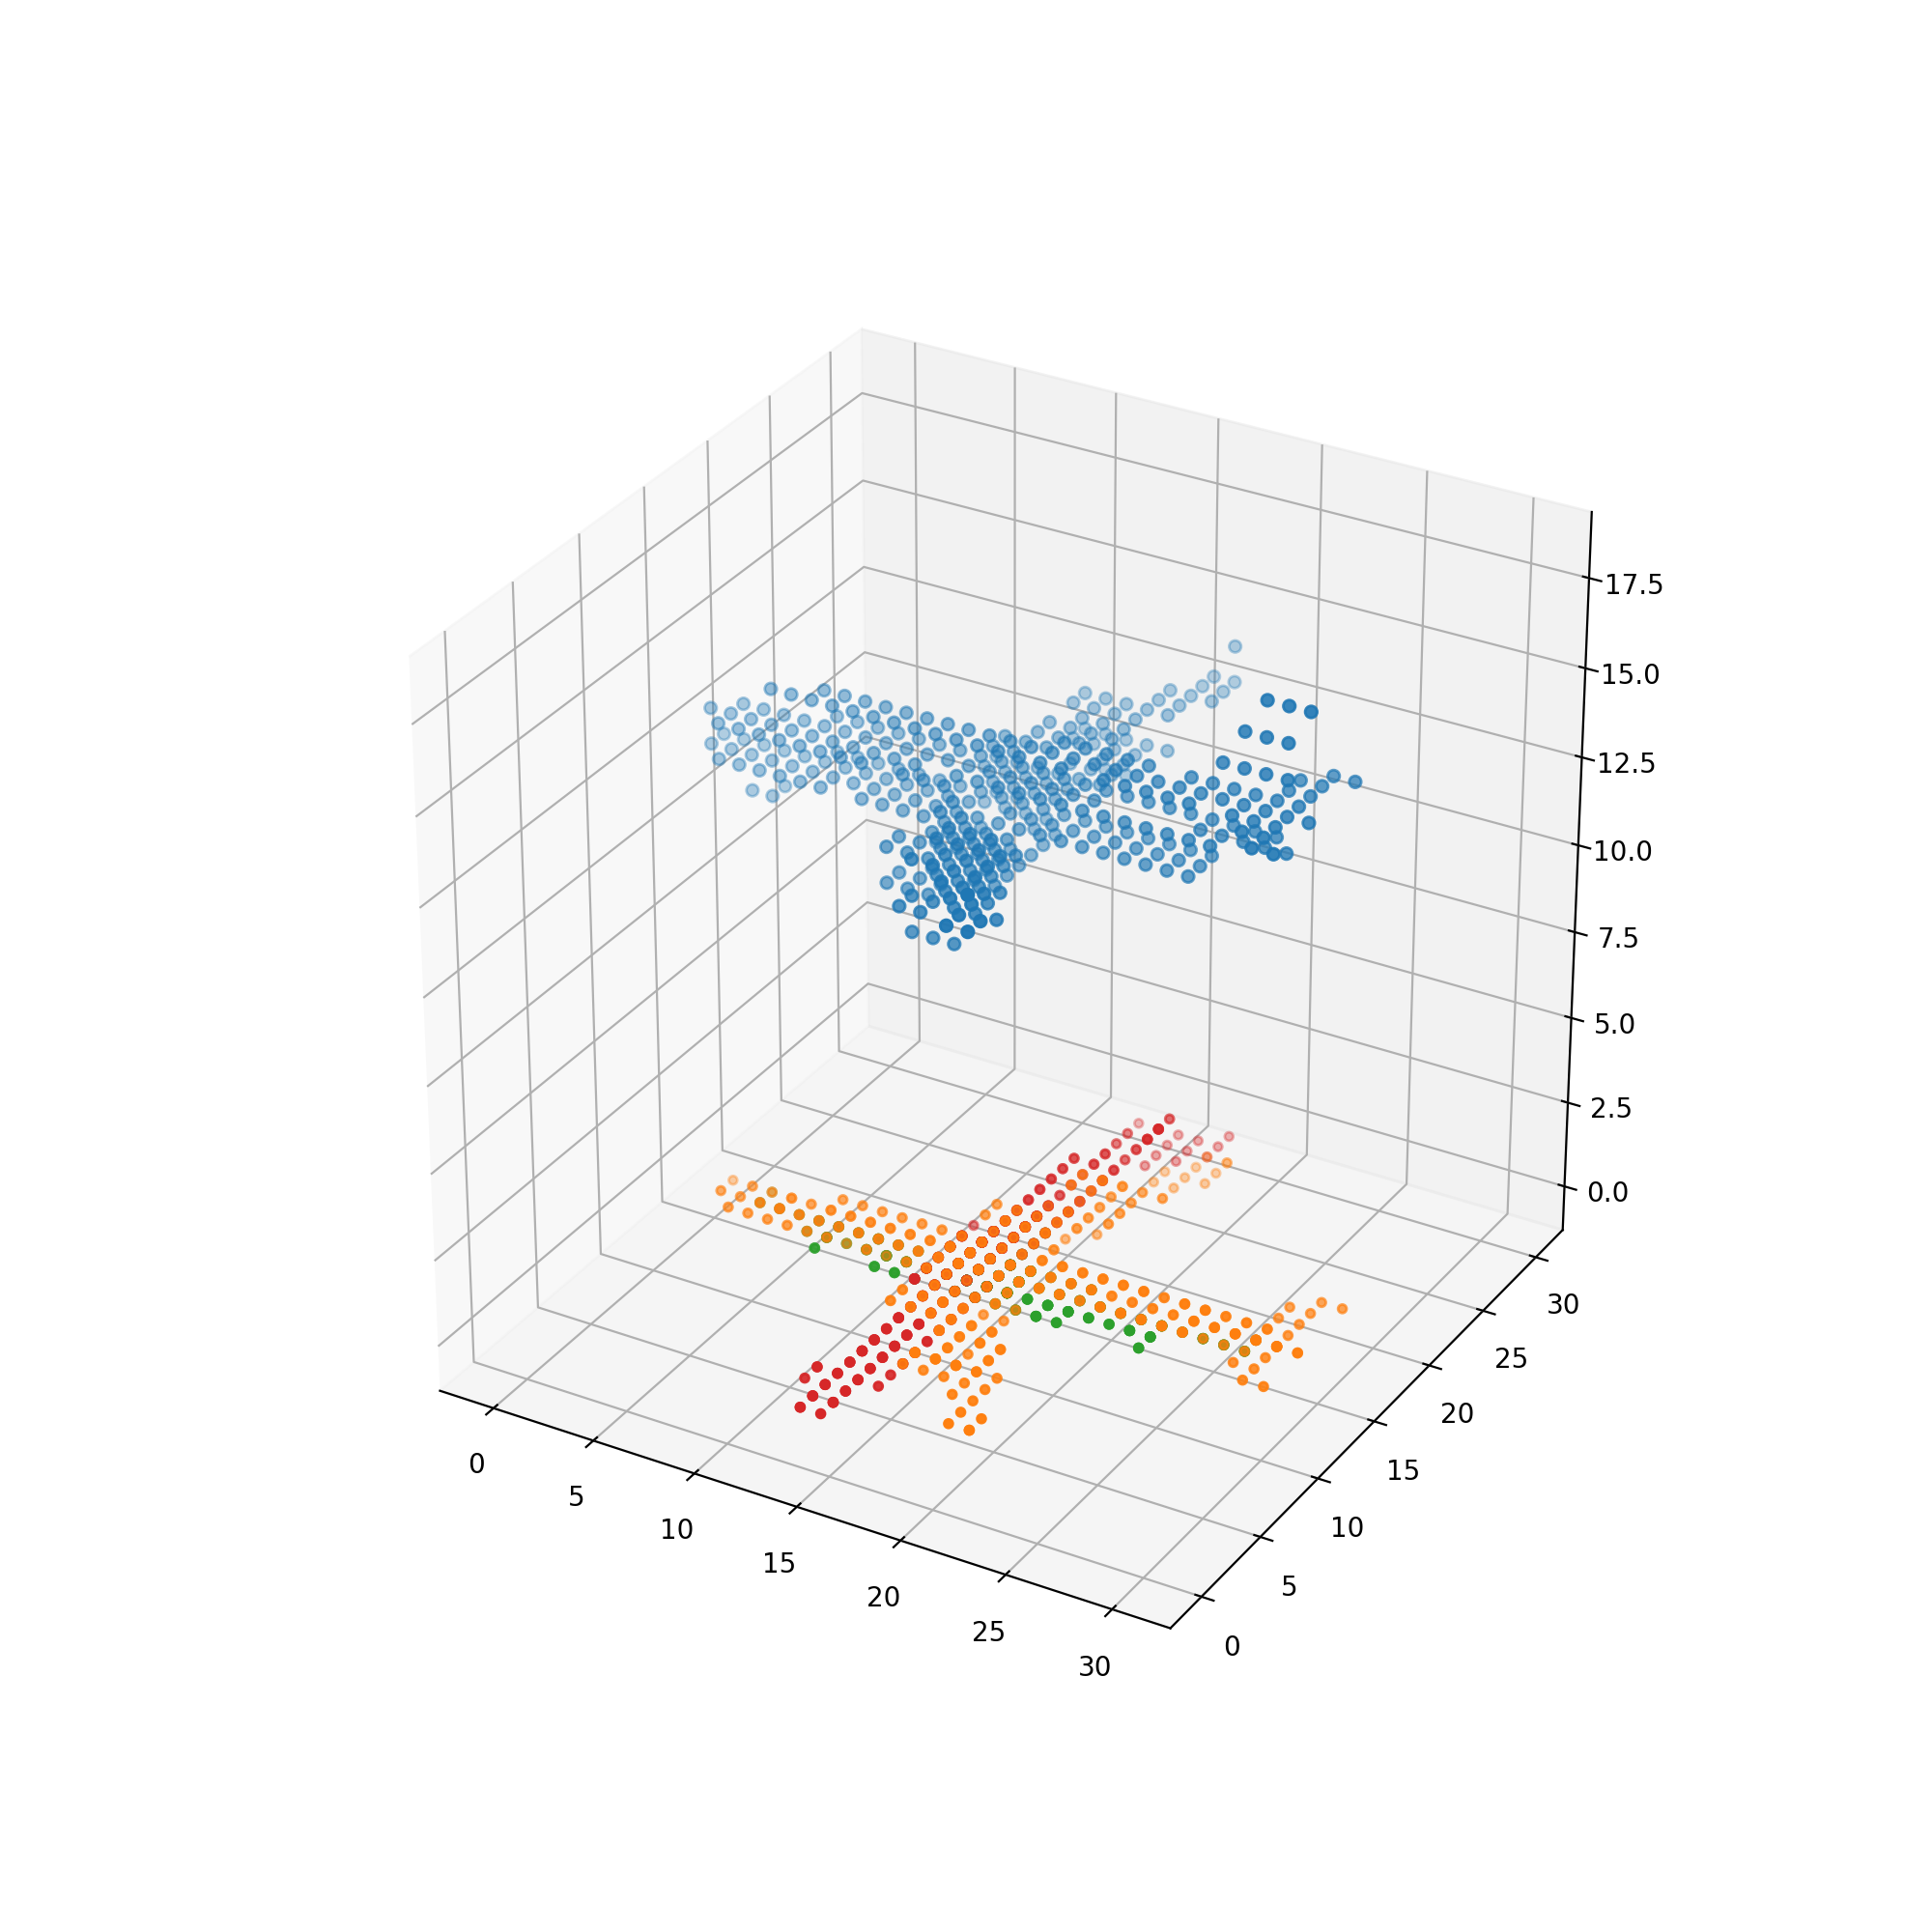

In [19]:
plot3D(test)

In [23]:
plot_trihedral_figure(test)

In [24]:
#voxelize
test_vox = voxilize(test)

In [25]:
#turn
vox_scat = voxel_scatter(test_vox)
plot3D(vox_scat)
plot_trihedral_figure_vox(vox_scat)

In [26]:
test_vox.shape

(1, 1, 32, 32, 32)

In [29]:
os.mkdir("data")

for t in train_or_test:
    for cl in class_name_modelnet40:
        print(cl)
        num = glob.glob("ModelNet40/"+ cl +"/" + t + "/*")
        for i in range(len(num)):
            print(i)
            if i ==0  :
                off = load_vox("ModelNet40/" + cl + "/" + t +"/"+ str(i) + ".off")
                continue
            off_ =  load_vox("ModelNet40/" + cl + "/" + t +"/"+ str(i) + ".off")
            off = np.append(off, off_, axis=0)
        np.save("data/" + cl + t + ".npy", off)
#クラス毎，TestTrain毎ボクセル化されたnpzが生成される（N,1,32,32,32）

airplane
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

ValueError: invalid literal for int() with base 10: '-0.933000'

In [31]:
int(-6.933000)

-6

In [32]:
list(map(int(float), off[1].split(" ")))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'type'